a. Explain the architecture of LSTM and GRU in detail. What were the shortcomings of RNN that were resolved by LSTM and GRU.

**LSTM Architecture (Long Short-Term Memory)**

LSTM is used to address the memory and gradient issues in RNN. It introduces a cell state and three gates to regulate information flow.

It has few coponenets as follows:
1. cell state -> It carries long-term memory across time steps.
2. Forget gate -> Decides what information to discard from the cell state.
3. INput gate -> Determines which new information to add to the cell state.
4. output gate -> Controls what part of the cell state is output as the hidden state.

The cell state allows gradients to flow more smoothly, mitigating vanishing gradients and enabling long-term memory retention.

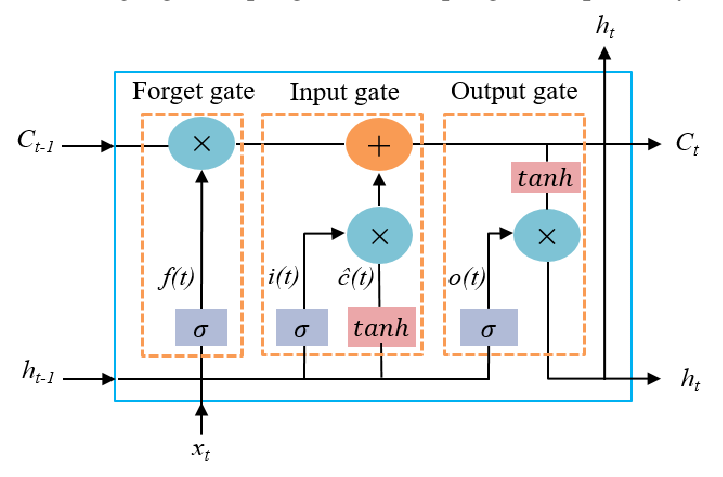

**Image referenced from google**

Memoery retention -> Long-term via cell state



**GRU (Gated Recurrent Unit)**

GRU is the simpler version of LSTM while retaining its benefits. It merges the cell and hidden states and uses two gates.

Componenet for GRU is:
1. Update gate -> Combines input and forget gates,it decides how much past information to retain.
2. Reset gate -> Controls how much past information to forget when computing the new state.

Memory Retention ->Long-term via hidden state


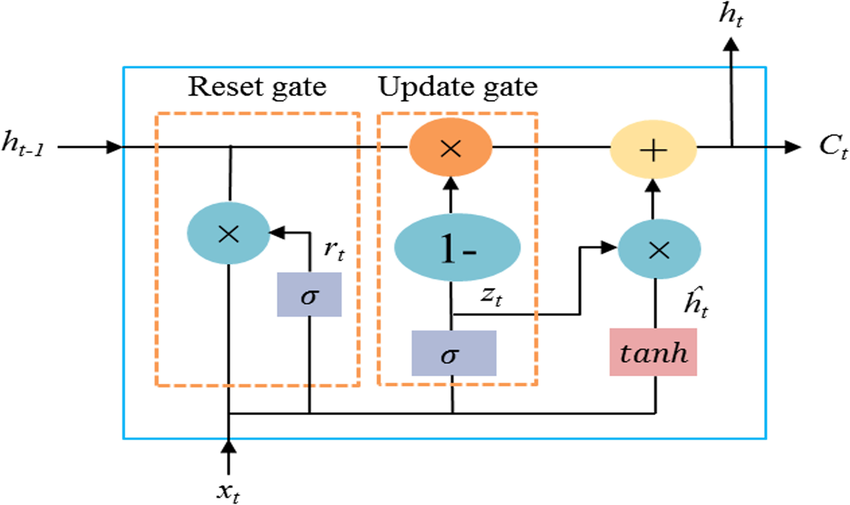


** Image refrence taken from google**

Below are the shortcomings for RNNs

1. Vanishing and Exploding Gradients ->
During backpropagation through time (BPTT), gradients can shrink or grow exponentially.This makes it difficult for RNNs to learn long-term.

2. Limited Memory Retention ->
RNNs rely on the hidden state to carry information forward.
This hidden state is overwritten at each time step, making it hard to retain over long sequences.

3. RNN could not decide what information to keep, discard, or send as output.





In [ ]:
!pip install gensim

b. Use the emotions detection dataset from below Kaggle link and create an end-to-end project on Jupyter/Colab to predict the person’s emotions.

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp/data

*   Download the dataset from above link and load it in your Python environment.
*   Perform the data cleaning like stopwords removal, lowercase, stemming, lemmatization etc.
*   Perform feature engineering and word embedding techniques like TFIDF, word2Vec, Bag of words etc.
*  Use the ML algorithms like logistic reg, DT, random forest etc. to predict the emotions.
*   Do the hyperparameter tuning to get the best model.
*   Finally create a table to compare the performances of all the models and suggest the best model.








In [ ]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Download NLTK resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("punkt_tab")

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.models import Word2Vec
from textblob import TextBlob
from nltk.probability import FreqDist


In [ ]:


# Download latest version (will be downloaded to /kaggle/input/...)
dataset_path = kagglehub.dataset_download("praveengovi/emotions-dataset-for-nlp")

# Define the desired destination path
destination_path = "/content/"

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Copy the contents of the downloaded dataset to the destination path
# We use shell command for simplicity, you could also use shutil.copytree
!cp -r "{dataset_path}/." "{destination_path}/"

print(f"Dataset copied to: {destination_path}")

# List files in the destination directory to confirm
!ls "{destination_path}"

In [ ]:
train_df = pd.read_csv("/content/train.txt", names=["text", "label"], sep=";")
test_df = pd.read_csv("/content/test.txt", names=["text", "label"], sep=";")
val_df = pd.read_csv("/content/val.txt", names=["text", "label"], sep=";")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Val shape:", val_df.shape)

train_df.head()


In [ ]:
print(train_df['label'].value_counts())
print(train_df.isnull().sum())


In [ ]:
print(test_df['label'].value_counts())
print(test_df.isnull().sum())


In [ ]:
print(val_df['label'].value_counts())
print(val_df.isnull().sum())


In [ ]:
plt.figure(figsize= (8, 6))
plt.xticks(rotation= 45, ha='right')
sns.countplot(x=train_df['label'], order=train_df['label'].value_counts().index, palette='viridis')
plt.title('Distribution of Emotions in Training Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):

    #Lowercase
    text = text.lower()
    for c in string.punctuation:
        text = text.replace(c, "")

    #Remove special characters & digits
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    #Tokenize
    tokens = nltk.word_tokenize(text)
    #stopwords
    tokens = [t for t in tokens if t not in stop_words]
    #stemming
    tokens = [stemmer.stem(t) for t in tokens]
    #lemmatization
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)

train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)
val_df["clean_text"] = val_df["text"].apply(clean_text)

train_df.head()


In [ ]:
train_df = train_df.drop('text', axis=1)
test_df = test_df.drop('text', axis=1)
val_df = val_df.drop('text', axis=1)

In [ ]:
train_df

In [ ]:
#spellingCorrected
# train_df["clean_text"] = train_df["clean_text"].apply(lambda x: str(TextBlob(x).correct()))
# train_df

In [ ]:
#spellingCorrected
# test_df["clean_text"] = test_df["clean_text"].apply(lambda x: str(TextBlob(x).correct()))
# val_df["clean_text"] = val_df["clean_text"].apply(lambda x: str(TextBlob(x).correct()))



In [ ]:
freqDist = nltk.FreqDist(train_df["clean_text"]).most_common(50)
freqDist2 = dict(freqDist)
freqDist2

In [ ]:
from wordcloud import WordCloud

myWordCloud = WordCloud().generate_from_frequencies(freqDist2)

plt.imshow(myWordCloud)
plt.axis('off')

In [ ]:
#bag of words
bow = CountVectorizer()
X_train_bow = bow.fit_transform(train_df["clean_text"])
X_test_bow = bow.transform(test_df["clean_text"])
X_val_bow = bow.transform(val_df["clean_text"])

print("BoW shape:", X_train_bow.shape)


In [ ]:
print(X_train_bow[:5].toarray())

print(bow.get_feature_names_out())

In [ ]:
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(train_df["clean_text"])
X_test_tfidf = tfidf.transform(test_df["clean_text"])
X_val_tfidf = tfidf.transform(val_df["clean_text"])

y_train_tfidf = train_df["label"]
y_test_tfidf = test_df["label"]
y_val_tfidf = val_df["label"]

print("Feature matrix shape:", X_train_tfidf.shape)


In [ ]:
print(X_train_tfidf[:5].toarray())

print(tfidf.get_feature_names_out())


In [ ]:
tokens = [text.split() for text in train_df['clean_text']]
w2v_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1)
print("W2V vocab size:", len(w2v_model.wv))

train_tokens = [word_tokenize(t) for t in train_df["clean_text"]]
test_tokens  = [word_tokenize(t) for t in test_df["clean_text"]]
val_tokens  = [word_tokenize(t) for t in val_df["clean_text"]]


# Train Word2Vec
w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4, epochs=10)
w2v_model.save("w2v_emotions.model")
print("W2V vocab size:", len(w2v_model.wv))


In [ ]:
w2v_model.wv.most_similar("love")

In [ ]:
# y label
le = LabelEncoder()
le.fit(train_df["label"])  # fit on training labels
y_train = le.transform(train_df["label"])
y_test = le.transform(test_df["label"])
y_val = le.transform(val_df["label"])

classes = le.classes_
print("Classes:", classes)


In [ ]:
y_train

In [ ]:
#token sequences to averaged Word2Vec sentence vectors
def avg_w2v_vectors(tokens_list, model, vector_size=100):
    features = np.zeros((len(tokens_list), vector_size))
    for i, tokens in enumerate(tokens_list):
        vecs = [model.wv[word] for word in tokens if word in model.wv]
        if len(vecs) > 0:
            features[i] = np.mean(vecs, axis=0)
        else:
            features[i] = np.zeros(vector_size)
    return features

X_train_w2v = avg_w2v_vectors(train_tokens, w2v_model, vector_size=100)
X_test_w2v  = avg_w2v_vectors(test_tokens,  w2v_model, vector_size=100)
print("Word2Vec shapes:", X_train_w2v.shape, X_test_w2v.shape)


In [ ]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=200),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "MultinomialNB": MultinomialNB(),
    "Bagging": BaggingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
}

# Voting using LR, RF, DT
voting_clf = VotingClassifier(estimators=[
    ("lr", LogisticRegression(max_iter=200)),
    ("rf", RandomForestClassifier()),
    ("dt", DecisionTreeClassifier())
], voting="hard")
models["Voting"] = voting_clf


def evaluate_model(model, X_train, y_train, X_test, y_test):
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"Model {model.__class__.__name__} training failed:", e)
        return None
    y_pred = model.predict(X_test)
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0)
    }

# Evaluating each model
results = []
feature_sets = {
    "BoW": (X_train_bow, X_test_bow),
    "TFIDF": (X_train_tfidf, X_test_tfidf),
    "Word2Vec": (X_train_w2v, X_test_w2v)
}

for feat_name, (X_tr, X_te) in feature_sets.items():
    print("\n==== Feature set:", feat_name)
    for model_name, model in models.items():
        print("Training:", model_name)
        res = evaluate_model(model, X_tr, y_train, X_te, y_test)
        if res is None:

            continue
        res_row = {
            "feature_set": feat_name,
            "model": model_name,
            **res
        }
        results.append(res_row)
        print(model_name, "F1(macro):", res_row["f1_macro"])


In [ ]:
#Results dataframe
results_df = pd.DataFrame(results)

results_df = results_df[["feature_set", "model", "accuracy", "precision_macro", "recall_macro", "f1_macro"]]

results_df = results_df.sort_values(["feature_set", "f1_macro"], ascending=[True, False]).reset_index(drop=True)
results_df


In [ ]:
pivot_results = results_df.pivot_table(index='model', columns='feature_set', values='f1_macro')
pivot_results.plot(kind='bar', figsize=(12, 8))
plt.title('F1 Macro Score by Model and Feature Set')
plt.xlabel('Model')
plt.ylabel('F1 Macro Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
results_df.to_csv("ml_model_results.csv", index=False)


In [ ]:
# Best model by F1 (macro)
best_idx = results_df["f1_macro"].idxmax()
best = results_df.loc[best_idx]
print("Best overall model:")
print(best)


In [ ]:
# classification report
best_model_name = best["model"]
best_feat = best["feature_set"]
print("Best model:", best_model_name, "on feature set:", best_feat)


best_model = models[best_model_name]
X_tr, X_te = feature_sets[best_feat]
best_model.fit(X_tr, y_train)
y_pred = best_model.predict(X_te)
print(classification_report(y_test, y_pred, target_names=le.inverse_transform(range(len(classes)))))


In [ ]:
X_tr, X_te = feature_sets["TFIDF"]

# Logistic Regression hyperparams
lr_params = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs", "saga"]
}
lr = LogisticRegression(max_iter=500)
grid_lr = GridSearchCV(lr, lr_params, cv=3, scoring="f1_macro", n_jobs=-1, verbose=2)
grid_lr.fit(X_tr, y_train)
print("Best Logistic Regression:", grid_lr.best_params_, "F1:", grid_lr.best_score_)



In [ ]:
# Decision Tree hyperparams
dt_params = {
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "criterion": ["gini", "entropy"]
}
dt = DecisionTreeClassifier()
grid_dt = GridSearchCV(dt, dt_params, cv=3, scoring="f1_macro", n_jobs=-1, verbose=2)
grid_dt.fit(X_tr, y_train)
print("Best Decision Tree:", grid_dt.best_params_, "F1:", grid_dt.best_score_)



In [ ]:
# Random Forest hyperparams
rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "criterion": ["gini", "entropy"]
}
rf = RandomForestClassifier()
rand_rf = RandomizedSearchCV(rf, rf_params, cv=3, scoring="f1_macro", n_iter=10, n_jobs=-1, verbose=2, random_state=42)
rand_rf.fit(X_tr, y_train)
print("Best Random Forest:", rand_rf.best_params_, "F1:", rand_rf.best_score_)

# Evaluate the best tuned model on the test set
best_rf = rand_rf.best_estimator_
y_pred = best_rf.predict(X_te)
print("\nClassification Report for best RF on test set:")
print(classification_report(y_test, y_pred, target_names=le.inverse_transform(range(len(classes)))))


In [ ]:


# Using TF-IDF
X_tr, X_te = feature_sets["TFIDF"]

# XGBoost
xgb_params = {
    "n_estimators": [100, 200],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)

rand_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=xgb_params,
    n_iter=10,
    scoring="f1_macro",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rand_xgb.fit(X_tr, y_train)
print("Best XGBoost:", rand_xgb.best_params_, "F1:", rand_xgb.best_score_)

# Evaluate best XGB on test set
best_xgb = rand_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_te)
print("\nClassification Report for best XGBoost on test set:")
print(classification_report(y_test, y_pred_xgb, target_names=le.inverse_transform(range(len(classes)))))




In [ ]:
# LightGBM
lgb_params = {
    "n_estimators": [100, 200],
    "max_depth": [-1, 10, 20],
    "learning_rate": [0.01, 0.1],
    "num_leaves": [31, 50, 100],
    "subsample": [0.7, 1.0]
}

lgb = LGBMClassifier(random_state=42)

rand_lgb = RandomizedSearchCV(
    lgb,
    param_distributions=lgb_params,
    n_iter=10,
    scoring="f1_macro",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rand_lgb.fit(X_tr, y_train)
print("Best LightGBM:", rand_lgb.best_params_, "F1:", rand_lgb.best_score_)

# Evaluate best LGB on test set
best_lgb = rand_lgb.best_estimator_
y_pred_lgb = best_lgb.predict(X_te)
print("\nClassification Report for best LightGBM on test set:")
print(classification_report(y_test, y_pred_lgb, target_names=le.inverse_transform(range(len(classes)))))


In [ ]:
best_models = {
    "LogisticRegression": grid_lr.best_estimator_,
    "DecisionTree": grid_dt.best_estimator_,
    "RandomForest": rand_rf.best_estimator_,
    "XGBoost": rand_xgb.best_estimator_
}


In [ ]:
comparison_results = []

# Iterate through rows of results_df
for index, row in results_df.iterrows():
    comparison_results.append({
        "Model": row["model"],
        "Type": "Default",
        "Accuracy": row["accuracy"],
        "F1_macro": row["f1_macro"]
    })

for model_name, tuned_model in best_models.items():
    y_pred = tuned_model.predict(X_te)
    comparison_results.append({
        "Model": model_name,
        "Type": "Tuned",
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1_macro": f1_score(y_test, y_pred, average="macro")
    })

# Add tuned LightGBM (XGBoost is already in best_models)
y_pred_lgb = best_lgb.predict(X_te)
comparison_results.append({
    "Model": "LightGBM",
    "Type": "Tuned",
    "Accuracy": accuracy_score(y_test, y_pred_lgb),
    "F1_macro": f1_score(y_test, y_pred_lgb, average="macro")
})


df_results = pd.DataFrame(comparison_results)
df_results = df_results.sort_values(by="F1_macro", ascending=False).reset_index(drop=True)

display(df_results)

In [ ]:
# Save the combined results
df_results.to_csv("df_results.csv", index=False)
display(df_results.sort_values(by="F1_macro", ascending=False).reset_index(drop=True))

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_results,x="Model",y="F1_macro",hue="Type",palette="Set2",errorbar=None)
plt.title("Default vs Tuned Models - F1 Macro Comparison", fontsize=14, fontweight="bold")
plt.ylabel("F1 Macro Score")
plt.xlabel("Model")
plt.xticks(rotation=30)
plt.legend(title="Model Type")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=df_results,x="Model",y="Accuracy",hue="Type",palette="Set1",errorbar=None)
plt.title("Default vs Tuned Models - Accuracy Comparison", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=30)
plt.legend(title="Model Type")
plt.show()


**Observations**

XGBoost (Tuned) achieved the highest accuracy (86.1%) and strong F1-macro (~0.805), showing it generalizes well.

Logistic Regression (Default) also performed competitively (85.8% accuracy, F1 ~0.807), nearly matching XGBoost.



c. Using the same Emotions Dataset for NLP from the Kaggle link in above question, now approach the problem using deep learning and transformer-based models.

Perform the following steps:

Download the dataset from above link and load it in your Python environment.

Perform the data cleaning like stopwords removal, lowercase, stemming, lemmatization etc.

Use DL models like Simple RNN, LSTM, GRU, Bidirectional RNN/LSTM/GRU, Stacked RNN/LSTM/GRU

Use the KerasTuner to tune the parameters.

Now use the pretrained models - BERT, DistilBERT, RoBERTa

Check for overfitting and underfitting

Finally create a table to compare the performances of all the models and suggest the best model.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SimpleRNN ,GRU

In [ ]:
MAX_NUM_WORDS = 20000   # vocabulary size
MAX_SEQ_LEN = 200       # Sequence length (truncate/pad)


tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_text"])

# Convert text to sequence of integers
X_train_seq = tokenizer.texts_to_sequences(train_df["clean_text"])
X_test_seq  = tokenizer.texts_to_sequences(test_df["clean_text"])
X_val_seq   = tokenizer.texts_to_sequences(val_df["clean_text"])

# Pad sequences to fixed length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LEN, padding="post")
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LEN, padding="post")
X_val_pad   = pad_sequences(X_val_seq, maxlen=MAX_SEQ_LEN, padding="post")

# Labels
y_train = train_df["label"].astype("category").cat.codes.values
y_test  = test_df["label"].astype("category").cat.codes.values
y_val   = val_df["label"].astype("category").cat.codes.values


In [ ]:
EMBED_DIM = 128
NUM_CLASSES = len(set(y_train))  # number of emotion classes


In [ ]:


def build_simple_rnn():
    model = Sequential([
        Embedding(MAX_NUM_WORDS, EMBED_DIM, input_length=MAX_SEQ_LEN),
        SimpleRNN(64),
        Dense(NUM_CLASSES, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def build_lstm():
    model = Sequential([
        Embedding(MAX_NUM_WORDS, EMBED_DIM, input_length=MAX_SEQ_LEN),
        LSTM(64),
        Dense(NUM_CLASSES, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def build_gru():
    model = Sequential([
        Embedding(MAX_NUM_WORDS, EMBED_DIM, input_length=MAX_SEQ_LEN),
        GRU(64),
        Dense(NUM_CLASSES, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def build_bilstm():
    model = Sequential([
        Embedding(MAX_NUM_WORDS, EMBED_DIM, input_length=MAX_SEQ_LEN),
        Bidirectional(LSTM(64)),
        Dense(NUM_CLASSES, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def build_stacked_lstm():
    model = Sequential([
        Embedding(MAX_NUM_WORDS, EMBED_DIM, input_length=MAX_SEQ_LEN),
        LSTM(64, return_sequences=True),
        LSTM(64),
        Dense(NUM_CLASSES, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


In [ ]:
models = {
    # "SimpleRNN": build_simple_rnn(),
    "LSTM": build_lstm(),
    "GRU": build_gru(),
    "BiLSTM": build_bilstm(),
    "StackedLSTM": build_stacked_lstm()
}

results_dl_default = {}

for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(X_train_pad, y_train, epochs=200, batch_size=32,
                        validation_split=0.2, verbose=1)

    y_pred = model.predict(X_test_pad).argmax(axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    results_dl_default[name] = {"accuracy": acc, "f1_macro": f1}


In [ ]:
# results_dl_default
# Save the combined results
results_dl_default.to_csv("results_dl_default.csv", index=False)
df_results=pd.read("df_results.csv")

display(results_dl_default.sort_values(by="F1_macro", ascending=False).reset_index(drop=True))

In [ ]:
# Convert results_dl_default dictionary to DataFrame
df_results_dl = pd.DataFrame.from_dict(results_dl_default, orient='index').reset_index()
df_results_dl.columns = ['Model', 'Accuracy', 'F1_macro']
df_results_dl['Type'] = 'Default' # Assuming these are default DL models

# Load the existing ML results
existing_results_df = pd.read_csv("df_results.csv")

# Combine the dataframes
combined_results_df = pd.concat([existing_results_df, df_results_dl], ignore_index=True)

# Display the combined results
display(combined_results_df.sort_values(by="F1_macro", ascending=False).reset_index(drop=True))

In [ ]:
!pip install keras_tuner

In [ ]:
# Keras Tuner

import keras_tuner as kt


In [ ]:
# HYperparameter tuning
def build_lstm_tuned(hp):
    model = Sequential()
    model.add(Embedding(MAX_NUM_WORDS,
                        hp.Int("embed_dim", min_value=64, max_value=256, step=64),
                        input_length=MAX_SEQ_LEN))
    model.add(LSTM(units=hp.Int("units", 32, 128, step=32),
                   dropout=hp.Float("dropout", 0.2, 0.5, step=0.1)))
    model.add(Dense(NUM_CLASSES, activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

tuner = kt.RandomSearch(
    build_lstm_tuned,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    directory="tuner_dir",
    project_name="lstm_tuning"
)

tuner.search(X_train_pad, y_train, epochs=200, validation_split=0.2, batch_size=32)

best_lstm_tuned = tuner.get_best_models(num_models=1)[0]


In [ ]:
existing_results_df = pd.read_csv("ml_model_results.csv")


In [ ]:
comparison_dl = []

for model_name, res in results_dl_default.items():
    comparison_dl.append({
        "Model": model_name,
        "Type": "Default",
        "Accuracy": res["accuracy"],
        "F1_macro": res["f1_macro"]
    })

# Add tuned models
y_pred = best_lstm_tuned.predict(X_test_pad).argmax(axis=1)
comparison_dl.append({
    "Model": "LSTM",
    "Type": "Tuned",
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1_macro": f1_score(y_test, y_pred, average="macro")
})

df_results_dl = pd.DataFrame(comparison_dl).sort_values(by="F1_macro", ascending=False)
display(df_results_dl)


In [ ]:
# Append the deep learning results
combined_results_df = pd.concat([existing_results_df, df_results_dl], ignore_index=True)

In [ ]:
!pip install torch torchvision torchaudio
!pip install transformers datasets evaluate
!pip install scikit-learn


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
from datasets import Dataset


In [ ]:
# Downloading the dataset agin as I do not want to touch to above process (Done for experiment purpose)

# Download latest version (will be downloaded to /kaggle/input/...)
dataset_path = kagglehub.dataset_download("praveengovi/emotions-dataset-for-nlp")

# Define the desired destination path
destination_path = "/content/pretrained/"

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Copy the contents of the downloaded dataset to the destination path
# We use shell command for simplicity, you could also use shutil.copytree
!cp -r "{dataset_path}/." "{destination_path}/"

print(f"Dataset copied to: {destination_path}")

# List files in the destination directory to confirm
!ls "{destination_path}"

In [ ]:
train_pr_df = pd.read_csv("/content/pretrained/train.txt", names=["text", "label"], sep=";")
test_pr_df = pd.read_csv("/content/pretrained/test.txt", names=["text", "label"], sep=";")
val_pr_df = pd.read_csv("/content/pretrained/val.txt", names=["text", "label"], sep=";")

print("Train shape:", train_pr_df.shape)
print("Test shape:", test_pr_df.shape)
print("Val shape:", val_pr_df.shape)

train_pr_df.head()


In [ ]:
train_pr_df["clean_text"] = train_pr_df["text"].apply(clean_text)
test_pr_df["clean_text"] = test_pr_df["text"].apply(clean_text)
val_pr_df["clean_text"] = val_pr_df["text"].apply(clean_text)

In [ ]:
train_pr_df

In [ ]:
train_pr_df = train_pr_df.drop(columns=["text"])
test_pr_df = test_pr_df.drop(columns=["text"])
val_pr_df = val_pr_df.drop(columns=["text"])

In [ ]:
train_pr_df

In [ ]:
num_labels = train_pr_df["label"].nunique()
num_labels

In [ ]:
model_ckpts = {
    "bert": "bert-base-uncased",
    "distilbert": "distilbert-base-uncased",
    "roberta": "roberta-base"
}

train_pr = Dataset.from_pandas(train_pr_df)
val_pr = Dataset.from_pandas(val_pr_df)
test_pr = Dataset.from_pandas(test_pr_df)

def tokenize_function(examples, tokenizer):
    return tokenizer(examples["clean_text"], padding="max_length", truncation=True)

# Dictionary to store tokenized datasets for each model
encoded_datasets = {}

for name, ckpt in model_ckpts.items():
    print(f"\nTokenizing with {ckpt} ...")
    tokenizer = AutoTokenizer.from_pretrained(ckpt)

    train_encoded = train_pr.map(lambda batch: tokenize_function(batch, tokenizer), batched=True)
    val_encoded = val_pr.map(lambda batch: tokenize_function(batch, tokenizer), batched=True)
    test_encoded = test_pr.map(lambda batch: tokenize_function(batch, tokenizer), batched=True)

    # Save into dictionary
    encoded_datasets[name] = {
        "tokenizer": tokenizer,
        "train": train_encoded,
        "val": val_encoded,
        "test": test_encoded
    }


In [ ]:
bert_train = encoded_datasets["bert"]["train"]
distilbert_train = encoded_datasets["distilbert"]["train"]
roberta_train = encoded_datasets["roberta"]["train"]


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }


def tokenize_function(examples, tokenizer):
    return tokenizer(examples["clean_text"], padding="max_length", truncation=True)


results = {}


In [ ]:
for name, ckpt in model_ckpts.items():
    print(f"\n Training {name.upper()} ({ckpt}) ...")

    tokenizer = AutoTokenizer.from_pretrained(ckpt)

    # Convert string labels to integers
    train_encoded = encoded_datasets[name]["train"].map(lambda a: {'label': le.transform([a['label']])[0]})
    val_encoded = encoded_datasets[name]["val"].map(lambda a: {'label': le.transform([a['label']])[0]})
    test_encoded = encoded_datasets[name]["test"].map(lambda a: {'label': le.transform([a['label']])[0]})

    model = AutoModelForSequenceClassification.from_pretrained(ckpt, num_labels=num_labels)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"/content/pretrained/results/{name}",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_dir=f"/content/pretrained/logs/{name}",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none"
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_encoded,
        eval_dataset=val_encoded,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Train model
    trainer.train()

**Observation:**


---



Bert is giving best results ACCURACY of ~91% and F1 of ~92% (For PreTrained)

And in Machine Learning model LOgistic Regreesion is giving best F1 results of ~82%

**d. Explain the different types of feature engineering techniques like one hot encoding, bag of words, TFIDF etc. How word2vec is different from them. Explain its working with example.**

In NLP, one-hot-encoding is used to transform into binary vector data and binary vector length equals the size of the vocabulary.

**example ->
in above dataset we have target label as sadness, anger , love
so the converting into one-hot encoding (vector), we get results as**

**[1,0,0] for sadness**

**[0,1,0] for anger**

**[0,0,1] for love**


---
***Taking the exmaple from above dataset***
```
**Text**	----------------------------------------  **Label**

didnt feel humili ----------------------------------[1, 0, 0]

go feel hopeless damn hope around someon care -----	[1, 0, 0]

im grab minut post feel greedi wrong-----------------[0, 1, 0]

ever feel nostalg fireplac know still properti-------[0, 0, 1]

feel grouchi-----------------------------------------[0, 1, 0]
```









**bag of words**

It is used to convert text into numeric encoding, where each document,sentence, or paragraph converted into numeric parity.






```
Example sentences:
"I feel happy"
"I feel sad"

BOW representation

Sentence     	I	feel	happy	sad
I feel happy	1	1	1	0
I feel sad   	1	1	0	1
```



**TFIDF**

Term Frequency–Inverse Document Frequency



---

TF-IDF is a statistical measure used to evaluate how important a word is to a document relative to a corpus. It improves upon Bag of Words by weighing words based on their informativeness, not just frequency.

It does not capture semantic meaning of words like happy and joy will be considered as different word.



**word2vec**

Word2Vec is a neural embedding model that transforms words into dense vector representations based on their context in a corpus. Unlike one-hot encoding or Bag of Words, Word2Vec captures semantic relationships — so words like "happy" and "joy" end up close together in vector space.


Word2Vec is trained using one of two architectures:
1. **CBOW (Continuous Bag of Words)**

 Predicts a target word from surrounding context words.

Example: In ["I", "feel", "very", "today"], predict "happy".

2. **Skip-Gram**

Predicts surrounding context words from a target word.

Example: word "happy", predict ["I", "feel", "very", "today"].
Both models learn embeddings by maximizing the probability of correct predictions over a sliding window.


Although it has limitations also, like bank and river bank considered as same.

It does not handle OOV(out of vocabulary) unless it is retrained.
